In [1]:
import os 
import pickle
import jax 
from jax import grad, jit, vmap, jacfwd, jacrev
import emcee
import sacc
import jax_cosmo as jc
import jax.numpy as jnp
import numpy as np
import matplotlib.pylab as plt
from jax import config

# numpyro 
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMC, NUTS, BarkerMH, init_to_median
from numpyro.handlers import seed
from numpyro.infer import Predictive, SVI, Trace_ELBO
import numpyro.infer.autoguide as autoguide

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 15
config.update("jax_enable_x64", True)

# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".50"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

# use emulator or not 
jc.power.USE_EMU = True

ZMAX = 2.0
ELLMIN = 2
NELL = 30
ELLMAX_GC = 300
ELLMAX_WL = 3000

In [2]:
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [3]:
def get_nz(sfile, tracertype="wl"):
    tracers_names = list(sfile.tracers.keys())

    if tracertype == "wl":
        tname = "DESwl__"
    else:
        tname = "DESgc__"
    nbin = sum([tname in tracers_names[i] for i in range(len(tracers_names))])

    nz_distributions = list()
    for i in range(nbin):
        name = tname + str(i)
        distribution = sfile.tracers[name]
        jaxred = jc.redshift.custom_nz(
            distribution.z.astype("float64"),
            distribution.nz.astype("float64"),
            zmax=ZMAX,
        )
        nz_distributions.append(jaxred)

    return nz_distributions

In [4]:
def calculate_lmax_gc(sfile, kmax):
    tracers_names = list(sfile.tracers.keys())
    nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
    vanillacosmo = jc.Planck15()
    lmaxs = list()
    for i in range(nbin_gc):
        tracer = sfile.tracers[f'DESgc__{i}']
        zmid = jnp.average(jnp.asarray(tracer.z), weights=jnp.asarray(tracer.nz))
        chi = jc.background.radial_comoving_distance(vanillacosmo, 1./(1. + zmid))
        minmax = jnp.concatenate([10.*jnp.ones(1), kmax * chi - 0.5], dtype = int)
        lmax = jnp.max(minmax)
        lmaxs.append(lmax)
    return lmaxs

In [5]:
def scale_cuts(sfile, kmax = 0.15, lmin_wl = 30, lmax_wl = 2000):
    # First we remove all B-modes
    sfile.remove_selection(data_type='cl_bb')
    sfile.remove_selection(data_type='cl_be')
    sfile.remove_selection(data_type='cl_eb')
    sfile.remove_selection(data_type='cl_0b')

    tracers_names = list(sfile.tracers.keys())
    nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
    nbin_wl = sum(['DESwl__' in tracers_names[i] for i in range(len(tracers_names))])
    lmaxs_gc = calculate_lmax_gc(sfile, kmax)
    
    for i, lmax in enumerate(lmaxs_gc):
        print(f'Maximum ell is {lmax}')
        tname_1 = f'DESgc__{i}'
        
        # Remove from galaxy clustering
        sfile.remove_selection(data_type='cl_00', tracers=(tname_1, tname_1), ell__gt=lmax)
        
        # Remove from galaxy-galaxy lensing
        for j in range(nbin_wl):
            tname_2 = f'DESwl__{j}'
            sfile.remove_selection(data_type='cl_0e', tracers=(tname_1, tname_2), ell__gt=lmax)
    
    # apply scale cut for weak lensing 
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            tname_1 = f'DESwl__{i}'
            tname_2 = f'DESwl__{j}'
            sfile.remove_selection(data_type='cl_ee', tracers=(tname_1, tname_2), ell__gt= lmax_wl)
            sfile.remove_selection(data_type='cl_ee', tracers=(tname_1, tname_2), ell__lt= lmin_wl)
            
    return sfile

def get_data_type(tracer_combination):
    if "gc" in tracer_combination[0] and "gc" in tracer_combination[1]:
        dtype = "cl_00"
    elif "gc" in tracer_combination[0] and "wl" in tracer_combination[1]:
        dtype = "cl_0e"
    elif "wl" in tracer_combination[0] and "wl" in tracer_combination[1]:
        dtype = "cl_ee"
    return dtype

def get_ells_bandwindow(sfile, tracer_name_1, tracer_name_2, ellmax):
    
    dtype = get_data_type((tracer_name_1, tracer_name_2))    
    idx = sfile.indices(data_type=dtype, tracers=(tracer_name_1, tracer_name_2))
    window = sfile.get_bandpower_windows(idx)
    fine_ells = window.values
    indices = (fine_ells >= 2) & (fine_ells <= ellmax)
    fine_ells = jnp.asarray(fine_ells[indices], dtype = jnp.float32)
    bandwindow = jnp.asarray(window.weight[indices])
    return fine_ells, bandwindow

def extract_bandwindow(sfile):
    tracers_names = list(sfile.tracers.keys())
    nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
    nbin_wl = sum(['DESwl__' in tracers_names[i] for i in range(len(tracers_names))])
    
    # galaxy-galaxy 
    record_gc = []
    for i in range(nbin_gc):
        tracer_name = f'DESgc__{i}'
        key = f'{tracer_name},{tracer_name}'
        ells_gc, bandwindow = get_ells_bandwindow(sfile, tracer_name, tracer_name, ELLMAX_GC)
        record_gc.append(bandwindow)

    # galaxy-shear
    record_gc_wl = []
    for i in range(nbin_gc):
        for j in range(nbin_wl):
            tracer_name_1 = f'DESgc__{i}'
            tracer_name_2 = f'DESwl__{j}'
            key = f'{tracer_name_1},{tracer_name_2}'
            ells_gc_wl, bandwindow = get_ells_bandwindow(sfile, tracer_name_1, tracer_name_2, ELLMAX_GC)
            record_gc_wl.append(bandwindow)
            
    # shear-shear
    record_wl = []
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            tracer_name_1 = f'DESwl__{i}'
            tracer_name_2 = f'DESwl__{j}'
            key = f'{tracer_name_1},{tracer_name_2}'
            ells_wl, bandwindow = get_ells_bandwindow(sfile, tracer_name_1, tracer_name_2, ELLMAX_WL)
            record_wl.append(bandwindow)

    return (ells_gc, record_gc), (ells_gc_wl, record_gc_wl), (ells_wl, record_wl)

def extract_data_covariance(saccfile):
    tracers_names = list(saccfile.tracers.keys())
    nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
    nbin_wl = sum(['DESwl__' in tracers_names[i] for i in range(len(tracers_names))])
    
    indices = []
    # galaxy-galaxy
    for i in range(nbin_gc):
        tracer_name = f'DESgc__{i}'
        _, _, ind = saccfile.get_ell_cl('cl_00', tracer_name, tracer_name, return_cov=False, return_ind=True)
        indices += list(ind)

    # galaxy-shear
    for i in range(nbin_gc):
        for j in range(nbin_wl):
            tracer_name_1 = f'DESgc__{i}'
            tracer_name_2 = f'DESwl__{j}'
            _, _, ind = saccfile.get_ell_cl('cl_0e', tracer_name_1, tracer_name_2, return_cov=False, return_ind=True)
            indices += list(ind)
        
    # shear-shear
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            tracer_name_1 = f'DESwl__{i}'
            tracer_name_2 = f'DESwl__{j}'
            _, _, ind = saccfile.get_ell_cl('cl_ee', tracer_name_1, tracer_name_2, return_cov=False, return_ind=True)
            indices += list(ind)

    indices = np.array(indices)    
    covariance = saccfile.covariance.covmat[indices][:, indices]
    data = saccfile.mean[indices]
    return jnp.array(data), jnp.array(covariance)

def get_index_pairs(nbin1, nbin2=None, auto=False):
    cl_index = list()
    if nbin2 is not None:
        for i in range(nbin1):
            for j in range(nbin2):
                cl_index.append([i, j + nbin1])
    elif auto:
        for i in range(nbin1):
            cl_index.append([i, i])
    else:
        for i in range(nbin1):
            for j in range(i, nbin1):
                cl_index.append([i, j])
    return cl_index


def get_params_vec(cosmo, multiplicative, deltaz, ia_params , bias, deltaz_gc):
    mparam_1, mparam_2, mparam_3, mparam_4 = multiplicative
    dz1, dz2, dz3, dz4 = deltaz
    a_ia_param, eta_param = ia_params
    b1, b2, b3, b4, b5 = bias
    dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5 = deltaz_gc 
    return jnp.array(
        [
            cosmo.sigma8,
            cosmo.Omega_c,
            cosmo.Omega_b,
            cosmo.h,
            cosmo.n_s,
            mparam_1,
            mparam_2,
            mparam_3,
            mparam_4,
            dz1,
            dz2,
            dz3,
            dz4,
            a_ia_param,
            eta_param,
            b1, b2, b3, b4, b5, dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5
        ]
    )


def unpack_params_vec(params):
    cosmo = jc.Cosmology(
        sigma8=params[0],
        Omega_c=params[1],
        Omega_b=params[2],
        h=params[3],
        n_s=params[4],
        w0=-1.0,
        Omega_k=0.0,
        wa=0.0,
    )
    mparam_1, mparam_2, mparam_3, mparam_4 = params[5:9]
    dz1, dz2, dz3, dz4 = params[9:13]
    a_ia_param, eta_param = params[13], params[14]
    b1, b2, b3, b4, b5 = params[15], params[16], params[17], params[18], params[19]
    dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5 = params[20], params[21], params[22], params[23], params[24]
    return (
        cosmo,
        [mparam_1, mparam_2, mparam_3, mparam_4],
        [dz1, dz2, dz3, dz4],
        [a_ia_param, eta_param],
        [b1, b2, b3, b4, b5],
        [dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5]
    )

In [6]:
def interpolator(ellnew, ellcoarse, powerspectrum):
    ellnew_log = jnp.log(ellnew)
    ellcoarse_log = jnp.log(ellcoarse)
    powerspectrum_log = jnp.log(powerspectrum)
    ps_interp = jnp.interp(ellnew_log, ellcoarse_log, powerspectrum_log)
    return jnp.exp(ps_interp)

def get_bandpowers_gc(bandwindow_ells, bandwindow_matrix, ells_coarse, powerspectra, nbin_gc):
    recordbandpowers = []
    counter = 0
    for i in range(nbin_gc):
        cls_wl_interp = interpolator(bandwindow_ells, ells_coarse, powerspectra[counter])
        bandpowers = bandwindow_matrix[counter].T @ cls_wl_interp
        recordbandpowers.append(bandpowers)
        counter += 1
    return recordbandpowers

def get_bandpowers_gc_wl(bandwindow_ells, bandwindow_matrix, ells_coarse, powerspectra, nbin_gc, nbin_wl):
    recordbandpowers = []
    counter = 0
    for i in range(nbin_gc):
        for j in range(nbin_wl):
            cls_wl_interp = interpolator(bandwindow_ells, ells_coarse, powerspectra[counter])
            bandpowers = bandwindow_matrix[counter].T @ cls_wl_interp
            recordbandpowers.append(bandpowers)
            counter += 1
    return recordbandpowers

def get_bandpowers_wl(bandwindow_ells, bandwindow_matrix, ells_coarse, powerspectra, nbin_wl):
    recordbandpowers = []
    counter = 0
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            cls_wl_interp = interpolator(bandwindow_ells, ells_coarse, powerspectra[counter])
            bandpowers = bandwindow_matrix[counter].T @ cls_wl_interp
            recordbandpowers.append(bandpowers)
            counter += 1
    return recordbandpowers

In [7]:
def get_gc_powerspectra(parameters, jax_nz_gc):
    cosmo, multiplicative, deltaz_wl, (a_ia_param, eta_param), bias, deltaz_gc = unpack_params_vec(parameters)
    nbin_gc = len(deltaz_gc)
    gc_biases = [jc.bias.constant_linear_bias(bi) for bi in bias]  
    nz_gc_sys = [jc.redshift.systematic_shift(nzi, dzi, zmax=ZMAX) for nzi, dzi in zip(jax_nz_gc, deltaz_gc)]
    probes_gc = [jc.probes.NumberCounts(nz_gc_sys, gc_biases)]
    ells_coarse = jnp.geomspace(ELLMIN, ELLMAX_GC, NELL, dtype=jnp.float32)
    idx_pairs_gc = get_index_pairs(nbin_gc, auto=True)
    ps_gc = jc.angular_cl.angular_cl(cosmo, ells_coarse, probes_gc, index_pairs = idx_pairs_gc)
    return ps_gc, ells_coarse, nbin_gc

def get_gc_wl_powerspectra(parameters, jax_nz_gc, jax_nz_wl):
    cosmo, multiplicative, deltaz_wl, (a_ia_param, eta_param), bias, deltaz_gc = unpack_params_vec(parameters)
    nbin_gc = len(deltaz_gc)
    nbin_wl = len(deltaz_wl)
    
    # apply all the systematics here (shifts, multiplicative bias, intrinsic alignment)
    nz_wl_sys = [jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(jax_nz_wl, deltaz_wl)]
    nz_gc_sys = [jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(jax_nz_gc, deltaz_gc)]
    gc_biases = [jc.bias.constant_linear_bias(bi) for bi in bias] 
    b_ia = jc.bias.des_y1_ia_bias(a_ia_param, eta_param, 0.62)

    probes_gc = [jc.probes.NumberCounts(nz_gc_sys, gc_biases)]
    probes_wl = [jc.probes.WeakLensing(nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative)]
    probes_gc_wl = probes_gc + probes_wl

    ells_coarse = jnp.geomspace(ELLMIN, ELLMAX_GC, NELL, dtype=jnp.float32)
    idx_pairs_gc_wl = get_index_pairs(nbin_gc, nbin_wl, auto=False)
    ps_gc_wl = jc.angular_cl.angular_cl(cosmo, ells_coarse, probes_gc_wl, index_pairs = idx_pairs_gc_wl)
    return ps_gc_wl, ells_coarse, nbin_gc, nbin_wl

def get_wl_powerspectra(parameters, jax_nz_wl):
    cosmo, multiplicative, deltaz_wl, (a_ia_param, eta_param) = unpack_params_vec(parameters)[0:4]
    nbin_wl = len(deltaz_wl)
    
    nz_wl_sys = [jc.redshift.systematic_shift(nzi, dzi, zmax=ZMAX) for nzi, dzi in zip(jax_nz_wl, deltaz_wl)]
    b_ia = jc.bias.des_y1_ia_bias(a_ia_param, eta_param, 0.62)
    probes_wl = [jc.probes.WeakLensing(nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative)]

    ells_coarse = jnp.geomspace(ELLMIN, ELLMAX_WL, NELL, dtype=jnp.float32)
    idx_pairs_wl = get_index_pairs(nbin_wl, auto=False)
    ps_wl = jc.angular_cl.angular_cl(cosmo, ells_coarse, probes_wl, index_pairs=idx_pairs_wl)
    return ps_wl, ells_coarse, nbin_wl
    
def gc_bandpower_calculation(parameters, jax_nz_gc, bandwindow_ells, bandwindow_matrix):
    ps_gc, ells_coarse, nbin_gc = get_gc_powerspectra(parameters, jax_nz_gc)
    gc_bandpowers = get_bandpowers_gc(bandwindow_ells, bandwindow_matrix, ells_coarse, ps_gc, nbin_gc)
    return gc_bandpowers

def gc_wl_bandpower_calculation(parameters, jax_nz_gc, jax_nz_wl, bandwindow_ells, bandwindow_matrix):
    ps_gc_wl, ells_coarse, nbin_gc, nbin_wl = get_gc_wl_powerspectra(parameters, jax_nz_gc, jax_nz_wl)
    gc_wl_bandpowers = get_bandpowers_gc_wl(bandwindow_ells, bandwindow_matrix, ells_coarse, ps_gc_wl, nbin_gc, nbin_wl)
    return gc_wl_bandpowers
    
def wl_bandpower_calculation(parameters, jax_nz_wl, bandwindow_ells, bandwindow_matrix):
    ps_wl, ells_coarse, nbin_wl = get_wl_powerspectra(parameters, jax_nz_wl)
    wl_bandpowers = get_bandpowers_wl(bandwindow_ells, bandwindow_matrix, ells_coarse, ps_wl, nbin_wl)
    return wl_bandpowers

In [8]:
def get_bandpowers_probes(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
    theory_gc = gc_bandpower_calculation(parameters, jax_nz_gc, bw_gc[0], bw_gc[1])
    theory_gc_wl = gc_wl_bandpower_calculation(parameters, jax_nz_gc, jax_nz_wl, bw_gc_wl[0], bw_gc_wl[1])
    theory_wl = wl_bandpower_calculation(parameters, jax_nz_wl, bw_wl[0], bw_wl[1])
    return theory_gc, theory_gc_wl, theory_wl
    
def get_bandpowers_theory(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
    theory_gc, theory_gc_wl, theory_wl = get_bandpowers_probes(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)
    concat_theory_gc = jnp.concatenate(theory_gc)
    concat_theory_gc_wl = jnp.concatenate(theory_gc_wl)
    concat_theory_wl = jnp.concatenate(theory_wl)
    return jnp.concatenate([concat_theory_gc, concat_theory_gc_wl, concat_theory_wl])

In [9]:
def pickle_save(file: list, folder: str, fname: str) -> None:
    """Stores a list in a folder.
    Args:
        list_to_store (list): The list to store.
        folder_name (str): The name of the folder.
        file_name (str): The name of the file.
    """

    # create the folder if it does not exist
    os.makedirs(folder, exist_ok=True)

    # use compressed format to store data
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "wb") as dummy:
        pickle.dump(file, dummy)


def pickle_load(folder: str, fname: str):
    """Reads a list from a folder.
    Args:
        folder_name (str): The name of the folder.
        file_name (str): The name of the file.
    Returns:
        Any: the stored file
    """
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "rb") as dummy:
        file = pickle.load(dummy)
    return file

In [10]:
def model(data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl): 
    #  Cosmological params
    sigma8 = numpyro.sample("sigma8", dist.Uniform(0.6, 1.0))
    Omegac = numpyro.sample("Omegac", dist.Uniform(0.14, 0.35))
    Omegab = numpyro.sample("Omegab", dist.Uniform(0.03, 0.055))
    hubble = numpyro.sample("hubble", dist.Uniform(0.64, 0.82))
    ns = numpyro.sample("ns", dist.Uniform(0.87, 1.07))
   
    cosmo = jc.Cosmology(Omega_c=Omegac, sigma8=sigma8, Omega_b=Omegab, h=hubble, n_s=ns, w0=-1.0, Omega_k=0.0, wa=0.0)

    # multiplicative factor (weak lensing)
    m1 = numpyro.sample("m1", dist.Normal(0.012, 0.023))
    m2 = numpyro.sample("m2", dist.Normal(0.012, 0.023))
    m3 = numpyro.sample("m3", dist.Normal(0.012, 0.023))
    m4 = numpyro.sample("m4", dist.Normal(0.012, 0.023))
    multiplicative = [m1, m2, m3, m4]

    # shifts (weak lensing)
    dz_wl_1 = numpyro.sample("dz_wl_1", dist.Normal(-0.001, 0.016))  
    dz_wl_2 = numpyro.sample("dz_wl_2", dist.Normal(-0.019, 0.013))
    dz_wl_3 = numpyro.sample("dz_wl_3", dist.Normal(0.009, 0.011))
    dz_wl_4 = numpyro.sample("dz_wl_4", dist.Normal(-0.018, 0.022))
    dz_wl = [dz_wl_1, dz_wl_2, dz_wl_3, dz_wl_4]
    nbin_wl = len(dz_wl)
    
    # intrinsic alignment
    a_ia = numpyro.sample("a_ia", dist.Uniform(-1, 1))
    eta = numpyro.sample("eta", dist.Uniform(-5.0, 5.0))
    ia_params = [a_ia, eta]

    # multiplicative bias (galaxy clustering)
    b1 = numpyro.sample("b1", dist.Uniform(0.8, 3.0))
    b2 = numpyro.sample("b2", dist.Uniform(0.8, 3.0))
    b3 = numpyro.sample("b3", dist.Uniform(0.8, 3.0))
    b4 = numpyro.sample("b4", dist.Uniform(0.8, 3.0))
    b5 = numpyro.sample("b5", dist.Uniform(0.8, 3.0))
    
    bias = [b1, b2, b3, b4, b5]
    
    # shifts (galaxy clustering)
    dz_gc_1 = numpyro.sample("dz_gc_1", dist.Normal(0.0, 0.007))
    dz_gc_2 = numpyro.sample("dz_gc_2", dist.Normal(0.0, 0.007))
    dz_gc_3 = numpyro.sample("dz_gc_3", dist.Normal(0.0, 0.006))
    dz_gc_4 = numpyro.sample("dz_gc_4", dist.Normal(0.0, 0.01))
    dz_gc_5 = numpyro.sample("dz_gc_5", dist.Normal(0.0, 0.01))
    dz_gc = [dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5]

    parameters = get_params_vec(cosmo, multiplicative, dz_wl, ia_params, bias, dz_gc)
    theory = get_bandpowers_theory(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)
    sampling_distribution = dist.MultivariateNormal(theory, precision_matrix=precision)
    theory_sample = numpyro.sample("y", sampling_distribution, obs=data)
    log_prob = sampling_distribution.log_prob(theory_sample)
    return theory_sample, log_prob

## Data and Covariance

In [11]:
saccfile = sacc.Sacc.load_fits("data/cls_DESY1.fits")
jax_nz_wl = get_nz(saccfile, tracertype="wl")
jax_nz_gc = get_nz(saccfile, tracertype="gc")
saccfile_cut = scale_cuts(saccfile, kmax = 0.15, lmin_wl = 30, lmax_wl = 2000)
bw_gc, bw_gc_wl, bw_wl = extract_bandwindow(saccfile_cut)
data, covariance = extract_data_covariance(saccfile_cut)
precision = jnp.linalg.inv(covariance)
newcov = covariance + jnp.eye(data.shape[0]) * 1E-18
newprec = jnp.linalg.inv(newcov)

Maximum ell is 101
Maximum ell is 155
Maximum ell is 206
Maximum ell is 255
Maximum ell is 298


In [12]:
eigvals, eigvectors = jnp.linalg.eigh(newcov)

In [13]:
jnp.all(eigvals > 0) 

DeviceArray(True, dtype=bool)

In [14]:
eigvals, eigvectors = jnp.linalg.eigh(newprec)

In [15]:
jnp.all(eigvals > 0) 

DeviceArray(True, dtype=bool)

In [16]:
with seed(rng_seed=42):
    theory, logp = model(data, newprec, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

Using the emulator
Using the emulator
Using the emulator


## Plots

- to add plot for redshift distributions
- to add plot for data covariance matrix

In [26]:
cosmo = jc.Cosmology(sigma8=0.8521117261609208, Omega_c = 0.2393475153665476, Omega_b=0.05395308811150879, 
                     h = 0.6529206102826096, n_s=0.9330022578443745, w0=-1., Omega_k=0., wa=0.)

testparameter = get_params_vec(cosmo, 
                       [0.07377626, 0.18572161, -0.07526319, -0.10828671], 
                       [-0.00846738, -0.10025093, -0.00177734, -0.00968797], 
                       [0.35898907, -0.01135033], 
                       [1.33889417, 1.57640662, 1.59644491, 1.90517272, 1.93960129], 
                       [0.02246754, -0.00146808, 0.02051478, 0.00968391, -0.01231999])

cosmo, multiplicative, deltaz_wl, (a_ia_param, eta_param), bias, deltaz_gc = unpack_params_vec(testparameter) 

In [27]:
ps_wl, ells_coarse, nbin_wl = get_wl_powerspectra(testparameter, jax_nz_wl)
theory_gc, theory_gc_wl, theory_wl = get_bandpowers_probes(testparameter, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

Not using the emulator
Not using the emulator
Not using the emulator
Not using the emulator


In [28]:
cls_wl = []
counter = 0
for i in range(nbin_wl):
    for j in range(i, nbin_wl):
        cls_wl_interp = interpolator(bw_wl[0], ells_coarse, ps_wl[counter])
        cls_wl.append(cls_wl_interp)
        counter += 1

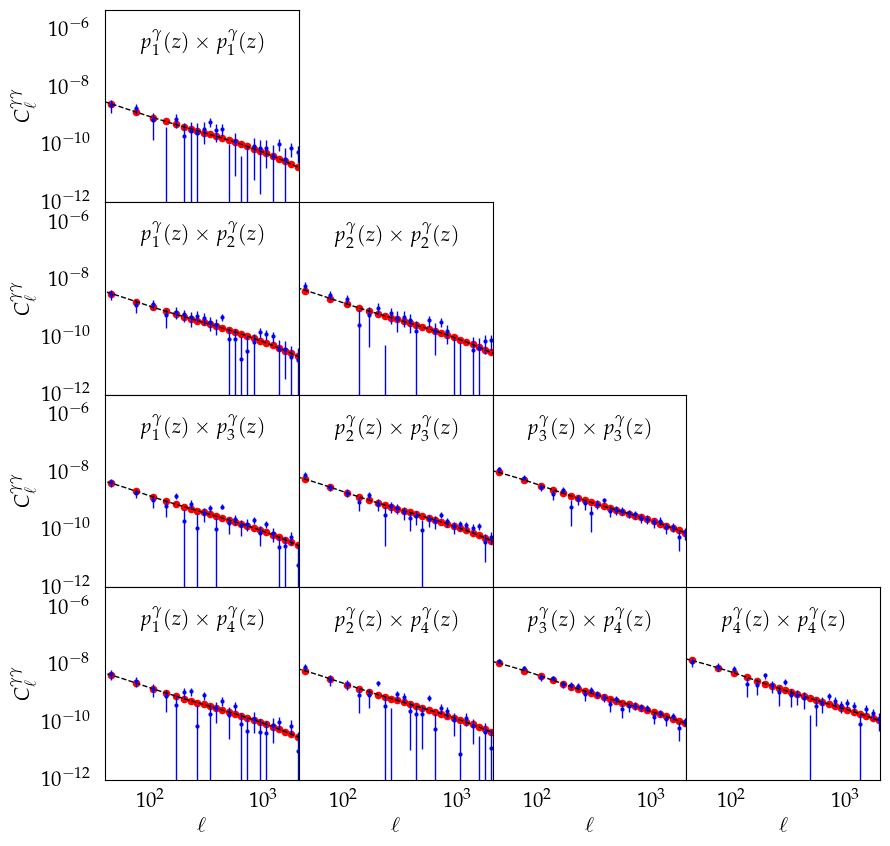

In [29]:
yLabel = r'$C_{\ell}^{\gamma\gamma}$'
xLabel = r'$\ell$'
ylims = [1E-12, 5E-6]
fontsize = fontSize

counter = 0

f, ax = plt.subplots(nbin_wl, nbin_wl, sharex=True, sharey = True, figsize = (10, 10))

for i in range(nbin_wl):
    for j in range(i, nbin_wl):

        labz = r'$p_{'+str(i+1)+'}^{\gamma}(z)\\times p_{'+str(j+1)+'}^{\gamma}(z)$'
        
        tracername_wl_i = f'DESwl__{i}'
        tracername_wl_j = f'DESwl__{j}'
        key = f'{tracername_wl_i},{tracername_wl_j}'
        
        ell, c_ell, covariance, indices = saccfile_cut.get_ell_cl('cl_ee', tracername_wl_i, tracername_wl_j, return_cov=True, return_ind=True)
        sigma = np.sqrt(np.diag(covariance))

        ax[j,i].errorbar(ell, c_ell, sigma, fmt='bo', ms=2, lw =1)
        ax[j,i].scatter(ell, theory_wl[counter], s = 20, c = 'r')
        ax[j,i].plot(bw_wl[0], cls_wl[counter], lw = 1, c = 'k', linestyle = '--')
        ax[j,i].set_xlabel(xLabel, fontsize=fontsize)
        ax[j,i].set_xlim(min(ell)-5, max(ell)+50)
        ax[j,i].set_ylim(ylims[0], ylims[1])
        ax[j,i].set_xscale("log")
        ax[j,i].set_yscale("log")
        ax[j,i].axhline(0, linestyle='--', c = 'k', lw = 0.5)
        ax[j,i].tick_params(axis = 'both', labelsize = fontsize, pad=10)
        ax[j,i].tick_params(axis='both', which='both', length=0)
        ax[j,i].annotate(labz, xy=(0.5, 0.80), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')

        if i==0 :
            ax[j, i].set_ylabel(yLabel, fontsize=fontsize)

        if j!=i:
            ax[i,j].axis('off')
            
        counter += 1
f.subplots_adjust(wspace=0)
f.subplots_adjust(hspace=0)
plt.show()

## Stochastic Variational Inference

This is not working. 

In [1]:
# NITER = 1000

# guide = autoguide.AutoMultivariateNormal(model, init_loc_fn=numpyro.infer.init_to_median, init_scale = 0.01)
# optimizer = numpyro.optim.Adam(step_size=0.001)
# svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# # model(data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)
# svi_result = svi.run(jax.random.PRNGKey(0), NITER, data, newprec, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

# predictive = Predictive(guide, params=svi_result.params, num_samples=1000)
# posterior_samples = predictive(jax.random.PRNGKey(1))

## HMC

This is not working well. 

In [ ]:
# NWARMUP = 200
# NSAMPLES = 5

# hmc_kernel = HMC(model, step_size=1.0, init_strategy=init_to_median, adapt_step_size=False, 
#                  adapt_mass_matrix=False, dense_mass=True, num_steps=10)

# mcmc_hmc = MCMC(hmc_kernel, num_warmup=NWARMUP, num_samples=NSAMPLES, num_chains=1, 
#             # chain_method="vectorized",
#             progress_bar=True)

# mcmc_nuts.run(jax.random.PRNGKey(253), data, newprec, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

## NUTS

In [25]:
nuts_kernel = NUTS(model, step_size=0.1, init_strategy=init_to_median, dense_mass=True, max_tree_depth=5)

In [26]:
mcmc_nuts = MCMC(nuts_kernel, num_warmup=NWARMUP, num_samples=NSAMPLES, num_chains=1, 
            # chain_method="vectorized",
            progress_bar=True)

In [29]:
# mcmc_nuts.run(jax.random.PRNGKey(253), data, newprec, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

## Barker MH

The results do not look good. 

In [ ]:
# barker_kernel = BarkerMH(model, step_size=0.1, init_strategy=init_to_median, dense_mass=True)
# mcmc_barker = MCMC(barker_kernel, num_warmup=NWARMUP, num_samples=NSAMPLES, progress_bar=True)

In [ ]:
# mcmc_barker.run(jax.random.PRNGKey(253), data, newprec, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

## EMCEE

In [30]:
@jax.jit
def jit_theory(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
    return get_bandpowers_theory(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

In [31]:
test_theory = jit_theory(testparameter, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

Not using the emulator
Not using the emulator
Not using the emulator


In [32]:
def emcee_loglike(parameters, data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
    theory = jit_theory(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)
    diff = data - theory 
    chi2 = diff @ precision @ diff
    return -0.5*jnp.min(jnp.array([chi2, 1E32]))

@jax.jit
def jit_emcee_loglike(parameters, data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
    return emcee_loglike(parameters, data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

@jax.jit
def jit_emcee_grad_loglike(parameters, data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
    return jax.jacrev(emcee_loglike)(parameters, data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

In [33]:
%%time
testlike = jit_emcee_loglike(testparameter, data, newprec, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

Not using the emulator
Not using the emulator
Not using the emulator
CPU times: user 41 s, sys: 96.4 ms, total: 41.1 s
Wall time: 37.8 s


In [34]:
%%timeit
testlike = jit_emcee_loglike(testparameter, data, newprec, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

36.2 ms ± 425 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
%%time
testgrad = jit_emcee_grad_loglike(testparameter, data, newprec, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

Not using the emulator
Not using the emulator
Not using the emulator
CPU times: user 3min 19s, sys: 703 ms, total: 3min 20s
Wall time: 3min 6s


In [36]:
%%timeit
testgrad = jit_emcee_grad_loglike(testparameter, data, newprec, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

158 ms ± 412 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
def emcee_logprior(parameters):

    # cosmological parameters 
    logp_sigma8 = jax.scipy.stats.uniform.logpdf(parameters[0], 0.60, 0.40)
    logp_omegac = jax.scipy.stats.uniform.logpdf(parameters[1], 0.14, 0.21)
    logp_omegab = jax.scipy.stats.uniform.logpdf(parameters[2], 0.03, 0.025)
    logp_hubble = jax.scipy.stats.uniform.logpdf(parameters[3], 0.64, 0.18)
    logp_ns = jax.scipy.stats.uniform.logpdf(parameters[4], 0.87, 0.20)

    # multiplicative factor (weak lensing)
    logp_m1 = jax.scipy.stats.norm.logpdf(parameters[5], 0.012, 0.023)
    logp_m2 = jax.scipy.stats.norm.logpdf(parameters[6], 0.012, 0.023)
    logp_m3 = jax.scipy.stats.norm.logpdf(parameters[7], 0.012, 0.023)
    logp_m4 = jax.scipy.stats.norm.logpdf(parameters[8], 0.012, 0.023)

    # shifts (weak lensing)
    logp_dz_wl_1 = jax.scipy.stats.norm.logpdf(parameters[9], -0.001, 0.016) 
    logp_dz_wl_2 = jax.scipy.stats.norm.logpdf(parameters[10], -0.019, 0.013)
    logp_dz_wl_3 = jax.scipy.stats.norm.logpdf(parameters[11], 0.009, 0.011)
    logp_dz_wl_4 = jax.scipy.stats.norm.logpdf(parameters[12], -0.018, 0.022)

    # intrinsic alignment
    logp_a_ia = jax.scipy.stats.uniform.logpdf(parameters[13], -1, 2)
    logp_eta = jax.scipy.stats.uniform.logpdf(parameters[14], -5, 10)  

    # multiplicative bias (galaxy clustering)
    logp_b1 = jax.scipy.stats.uniform.logpdf(parameters[15], 0.8, 2.2)
    logp_b2 = jax.scipy.stats.uniform.logpdf(parameters[16], 0.8, 2.2)
    logp_b3 = jax.scipy.stats.uniform.logpdf(parameters[17], 0.8, 2.2)
    logp_b4 = jax.scipy.stats.uniform.logpdf(parameters[18], 0.8, 2.2)
    logp_b5 = jax.scipy.stats.uniform.logpdf(parameters[19], 0.8, 2.2)

    # shifts (galaxy clustering)
    logp_dz_gc_1 = jax.scipy.stats.norm.logpdf(parameters[20], 0.0, 0.007)
    logp_dz_gc_2 = jax.scipy.stats.norm.logpdf(parameters[21], 0.0, 0.007)
    logp_dz_gc_3 = jax.scipy.stats.norm.logpdf(parameters[22], 0.0, 0.006)
    logp_dz_gc_4 = jax.scipy.stats.norm.logpdf(parameters[23], 0.0, 0.01)
    logp_dz_gc_5 = jax.scipy.stats.norm.logpdf(parameters[24], 0.0, 0.01)
    
    logp_cosmology = logp_sigma8 + logp_omegac + logp_omegab + logp_hubble + logp_ns 
    logp_multiplicative = logp_m1 + logp_m2 + logp_m3 + logp_m4 
    logp_shifts_wl = logp_dz_wl_1 + logp_dz_wl_2 + logp_dz_wl_3 + logp_dz_wl_4
    logp_intrinsic = logp_a_ia + logp_eta 
    logp_bias = logp_b1 + logp_b2 + logp_b3 + logp_b4 + logp_b5
    logp_shifts_gc = logp_dz_gc_1 + logp_dz_gc_2 + logp_dz_gc_3 + logp_dz_gc_4 + logp_dz_gc_5
    logp = logp_cosmology + logp_multiplicative + logp_shifts_wl + logp_intrinsic + logp_bias + logp_shifts_gc
    if not jnp.isfinite(logp):
        logp = -1E32
    return logp

def emcee_logpost(parameters, data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
    loglike = emcee_loglike(parameters, data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)
    logprior = emcee_logprior(parameters)
    return loglike + logprior    

In [ ]:
nparams = len(testparameter)
pos = testparameter + 1E-4 * jax.random.normal(jax.random.PRNGKey(0), (2*nparams, nparams))
nwalkers, ndim = pos.shape
nsamples = 500

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, emcee_logpost, args=(data, newprec, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl))
# sampler.run_mcmc(pos, nsamples, progress=True);

## Dynesty

Not working well - takes too long to converge and posterior does not look good.

In [63]:
@jax.jit
def jit_theory(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
    return get_bandpowers_theory(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

In [2]:
def unit_transform(random_number, xmin, xmax):
    return xmin + random_number * (xmax - xmin)

In [60]:
def dynesty_prior(unit_cube):
    parameter = jnp.array(unit_cube) 

    # cosmology
    parameter = parameter.at[0].set(unit_transform(parameter[0], 0.60, 1.0))
    parameter = parameter.at[1].set(unit_transform(parameter[1], 0.14, 0.35))
    parameter = parameter.at[2].set(unit_transform(parameter[2], 0.03, 0.055))
    parameter = parameter.at[3].set(unit_transform(parameter[3], 0.64, 0.82))
    parameter = parameter.at[4].set(unit_transform(parameter[4], 0.87, 1.07))

    # multiplicative
    parameter = parameter.at[5].set(jax.scipy.stats.norm.ppf(parameter[5], 0.012, 0.023))
    parameter = parameter.at[6].set(jax.scipy.stats.norm.ppf(parameter[6], 0.012, 0.023))
    parameter = parameter.at[7].set(jax.scipy.stats.norm.ppf(parameter[7], 0.012, 0.023))
    parameter = parameter.at[8].set(jax.scipy.stats.norm.ppf(parameter[8], 0.012, 0.023))

    # shifts 
    parameter = parameter.at[9].set(jax.scipy.stats.norm.ppf(parameter[9], -0.001, 0.016))
    parameter = parameter.at[10].set(jax.scipy.stats.norm.ppf(parameter[10], -0.019, 0.013))
    parameter = parameter.at[11].set(jax.scipy.stats.norm.ppf(parameter[11], 0.009, 0.011))
    parameter = parameter.at[12].set(jax.scipy.stats.norm.ppf(parameter[12], -0.018, 0.022))

    # intrinsic alignment
    parameter = parameter.at[13].set(unit_transform(parameter[13], -1.0, 1.0))
    parameter = parameter.at[14].set(unit_transform(parameter[14], -5.0, 5.0))
 
    # multiplicative bias (galaxy clustering)
    parameter = parameter.at[15].set(unit_transform(parameter[15], 0.8, 3.0))
    parameter = parameter.at[16].set(unit_transform(parameter[16], 0.8, 3.0))
    parameter = parameter.at[17].set(unit_transform(parameter[17], 0.8, 3.0))
    parameter = parameter.at[18].set(unit_transform(parameter[18], 0.8, 3.0))
    parameter = parameter.at[19].set(unit_transform(parameter[19], 0.8, 3.0))

    # shifts (galaxy clustering)
    parameter = parameter.at[20].set(jax.scipy.stats.norm.ppf(parameter[20], 0.0, 0.007))
    parameter = parameter.at[21].set(jax.scipy.stats.norm.ppf(parameter[21], 0.0, 0.007))
    parameter = parameter.at[22].set(jax.scipy.stats.norm.ppf(parameter[22], 0.0, 0.006))
    parameter = parameter.at[23].set(jax.scipy.stats.norm.ppf(parameter[23], 0.0, 0.01))
    parameter = parameter.at[24].set(jax.scipy.stats.norm.ppf(parameter[24], 0.0, 0.01))
    return parameter

In [100]:
def dynesty_loglike(parameters):
    theory = jit_theory(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)
    diff = data - theory 
    chi2 = diff @ newprec @ diff
    isnan = jnp.isnan(chi2)
    chi2 = jnp.where(isnan, 1E32, chi2)
    return -0.5*chi2

In [64]:
test_theory = jit_theory(testparameter, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

Not using the emulator
Not using the emulator
Not using the emulator


In [106]:
%%time
dynesty_loglike(testparameter)

CPU times: user 231 ms, sys: 23.9 ms, total: 255 ms
Wall time: 158 ms


Array(-89.4523185, dtype=float64)

In [75]:
# initialize our nested sampler
des_sampler = NestedSampler(dynesty_loglike, dynesty_prior, ndim=25)

In [2]:
# des_sampler.run_nested()

In [86]:
# pickle_save(des_sampler, 'samples', 'des_sampler_test')